In [12]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from robo_trader import Trader
from robo_trader.strategies import LorentzianStrategy, LorentzianSettings, LorentzianOptimizer, LorentzianOptimizerSettings
from robo_trader.feeds import YFinanceFeed
import json
import matplotlib.pyplot as plt



In [13]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
train_since = datetime(2024, 3, 11, tzinfo=timezone.utc)
start_date = datetime(2024, 4, 11, tzinfo=timezone.utc)
end_date = datetime(2024, 5, 11, tzinfo=timezone.utc)
period = 24

feed = YFinanceFeed(interval = '1h')

In [14]:
default_settings = LorentzianSettings(
    use_RSI=True,
    use_WT=True,
    use_CCI=True,
    use_ADX=False,
    use_MFI=True,
    useKernelSmoothing=True,
    useRegimeFilter=True,
    useAdxFilter=False,
    useVolatilityFilter=False,
    useEmaFilter=False,
    useSmaFilter=False,
    useDynamicExits=True,

    neighborsCount=8, maxBarsBack=720,
    emaPeriod=200, smaPeriod=200,
    lookbackWindow=16, relativeWeight=8.0, regressionLevel=18, crossoverLag=0,
    regimeThreshold=1, adxThreshold=20,
    RSI_param1=24, RSI_param2=5,
    WT_param1=6, WT_param2=11,
    CCI_param1=24, CCI_param2=6,
    ADX_param1=21, ADX_param2=2,
    MFI_param1=14,

    position_size = 0.25,
    trailing_stop = 0.005
)

optimizer_settings = LorentzianOptimizerSettings(
)

settings = LorentzianOptimizer.get_optimal_settings(
    SYMBOL, 1000, feed, optimizer_settings, default_settings, start_date, end_date, period, train_since
)

# Write settings to disk
settings_file_path = "Lorentzian_optimal_settings.json"
with open(settings_file_path, "w") as settings_file:
    settings_dict = settings.__dict__
    json.dump(settings_dict, settings_file, indent=4)
    
print(f"Optimal settings have been written to {settings_file_path}")

Optimal settings have been written to optimal_settings.json


In [15]:
with open(settings_file_path, "r") as settings_file:
    optimal_settings_data = json.load(settings_file)
    optimal_settings = LorentzianSettings(**optimal_settings_data)

strategy = LorentzianStrategy(default_settings)

# Create a Trader instance with the strategy
trader = Trader(SYMBOL, 1000, feed, strategy)

# Run the backtest
results = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)


Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£250.0) and 0.5% trail
    Creating MARKET BUY order for BTC-GBP at 52612.2890625 with quantity 0.004732734584199598, trail 0.005, limit None, stop None
    Executing MARKET BUY order for BTC-GBP at 52612.2890625 with quantity 0.004732734584199598, total cost £249.996 and transaction cost £0.996
    Bought 0.004732734584199598 BTC-GBP at 52612.2890625
    Creating TRAILING_STOP SELL order for BTC-GBP at 52612.2890625 with quantity 0.004732734584199598, trail 0.005, limit None, stop 52349.2276171875
    Executing TRAILING_STOP SELL order for BTC-GBP at 52346.58376171875 with quantity 0.004732734584199598, total cost £248.7334572831226 and transaction cost £0.9909699493351498
    Sold 0.004732734584199598 BTC-GBP at 52346.58376171875
Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£249.18887934611308) and 0.5% trail
    Crea

In [16]:
# Set display options
pd.set_option('display.max_rows', None)  # Adjust None to your specific needs
pd.set_option('display.max_columns', None)  # Adjust None as needed
pd.set_option('display.width', 1000)  # Adjust the width to fit your notebook

display(results['returns'])

# Display the results
# Filter the history DataFrame to show only rows with True in open_long or close_long columns
filtered_history = results['history'][(results['history']['open_long'] == True) | (results['history']['close_long'] == True)]

# Display the filtered results
display(filtered_history)

display(results['orders'])


,start_date,end_date,price_start,price_end,valuation_start,valuation_end,asset_return,portfolio_return
0,2024-04-11 00:00:00+00:00,2024-04-11 00:00:00+00:00,56343.437500,56244.683594,1000.000000,1000.000000,-0.001753,0.000000
1,2024-04-11 00:00:00+00:00,2024-04-12 00:00:00+00:00,56244.683594,56004.929688,1000.000000,1000.000000,-0.004263,0.000000
2,2024-04-12 00:00:00+00:00,2024-04-13 00:00:00+00:00,56004.929688,53707.167969,1000.000000,1000.000000,-0.041028,0.000000
3,2024-04-13 00:00:00+00:00,2024-04-14 00:00:00+00:00,53707.167969,51107.062500,1000.000000,1000.000000,-0.048413,0.000000
4,2024-04-14 00:00:00+00:00,2024-04-15 00:00:00+00:00,51107.062500,52612.289062,1000.000000,999.004000,0.029452,-0.000996
5,2024-04-15 00:00:00+00:00,2024-04-16 00:00:00+00:00,52612.289062,50873.664062,999.004000,996.755517,-0.033046,-0.002251
6,2024-04-16 00:00:00+00:00,2024-04-17 00:00:00+00:00,50873.664062,51509.640625,996.755517,996.755517,0.012501,0.000000
7,2024-04-17 00:00:00+00:00,2024-04-18 00:00:00+00:00,51509.640625,49380.281250,996.755517,996.755517,-0.041339,0.000000
8,2024-04-18 00:00:00+00:00,2024-04-19 00:00:00+00:00,49380.281250,50533.406250,996.755517,993.469783,0.023352,-0.003296
9,2024-04-19 00:00:00+00:00,2024-04-20 00:00:00+00:00,50533.406250,51407.269531,993.469783,993.469783,0.017293,0.000000


,open,high,low,close,volume,Dividends,Stock Splits,open_long,close_long
date,,,,,,,,,
2024-04-15 00:00:00+00:00,52775.769531,52885.183594,52485.019531,52612.289062,0,0.0,0.0,True,False
2024-04-15 02:00:00+00:00,52458.371094,52507.078125,52201.335938,52322.789062,0,0.0,0.0,False,True
2024-04-18 11:00:00+00:00,49587.710938,50540.894531,49587.710938,50281.285156,1465223168,0.0,0.0,True,False
2024-04-18 12:00:00+00:00,50215.933594,50264.144531,49536.675781,49899.292969,0,0.0,0.0,False,True
2024-04-28 03:00:00+00:00,51215.609375,51477.652344,51195.480469,51251.640625,408448000,0.0,0.0,True,False
2024-04-28 07:00:00+00:00,51211.007812,51228.097656,50556.625000,50559.613281,0,0.0,0.0,False,True
2024-04-29 22:00:00+00:00,50195.722656,50856.496094,50195.722656,50845.214844,0,0.0,0.0,True,False
2024-04-30 01:00:00+00:00,51413.683594,51420.222656,50672.816406,50672.816406,307384320,0.0,0.0,False,True
2024-05-07 09:00:00+00:00,51254.921875,51302.234375,51132.746094,51151.695312,0,0.0,0.0,True,False


{'b247df31-6244-481c-85ce-0686580e905b': Order(symbol='BTC-GBP', order_type='MARKET', order_side='BUY', quantity=0.004732734584199598, trail=0.005, limit=None, stop=None, id='b247df31-6244-481c-85ce-0686580e905b', timestamp=Timestamp('2024-04-15 00:00:00+0000', tz='UTC'), status='FILLED', trades=[Trade(id='bf72cd1e-93fe-4fd2-b3de-32610bd7f6a0', order_id='b247df31-6244-481c-85ce-0686580e905b', symbol='BTC-GBP', order_type='MARKET', order_side='BUY', price=52612.2890625, quantity=0.004732734584199598, timestamp=Timestamp('2024-04-15 00:00:00+0000', tz='UTC'), transaction_costs=0.996)]),
 '5fb769c6-04a6-4fe3-ab69-aa1599c76c7e': Order(symbol='BTC-GBP', order_type='TRAILING_STOP', order_side='SELL', quantity=0.004732734584199598, trail=0.005, limit=None, stop=52349.2276171875, id='5fb769c6-04a6-4fe3-ab69-aa1599c76c7e', timestamp=Timestamp('2024-04-15 00:00:00+0000', tz='UTC'), status='FILLED', trades=[Trade(id='0d97020c-8235-4aaa-a006-4916e81ff561', order_id='5fb769c6-04a6-4fe3-ab69-aa1599c

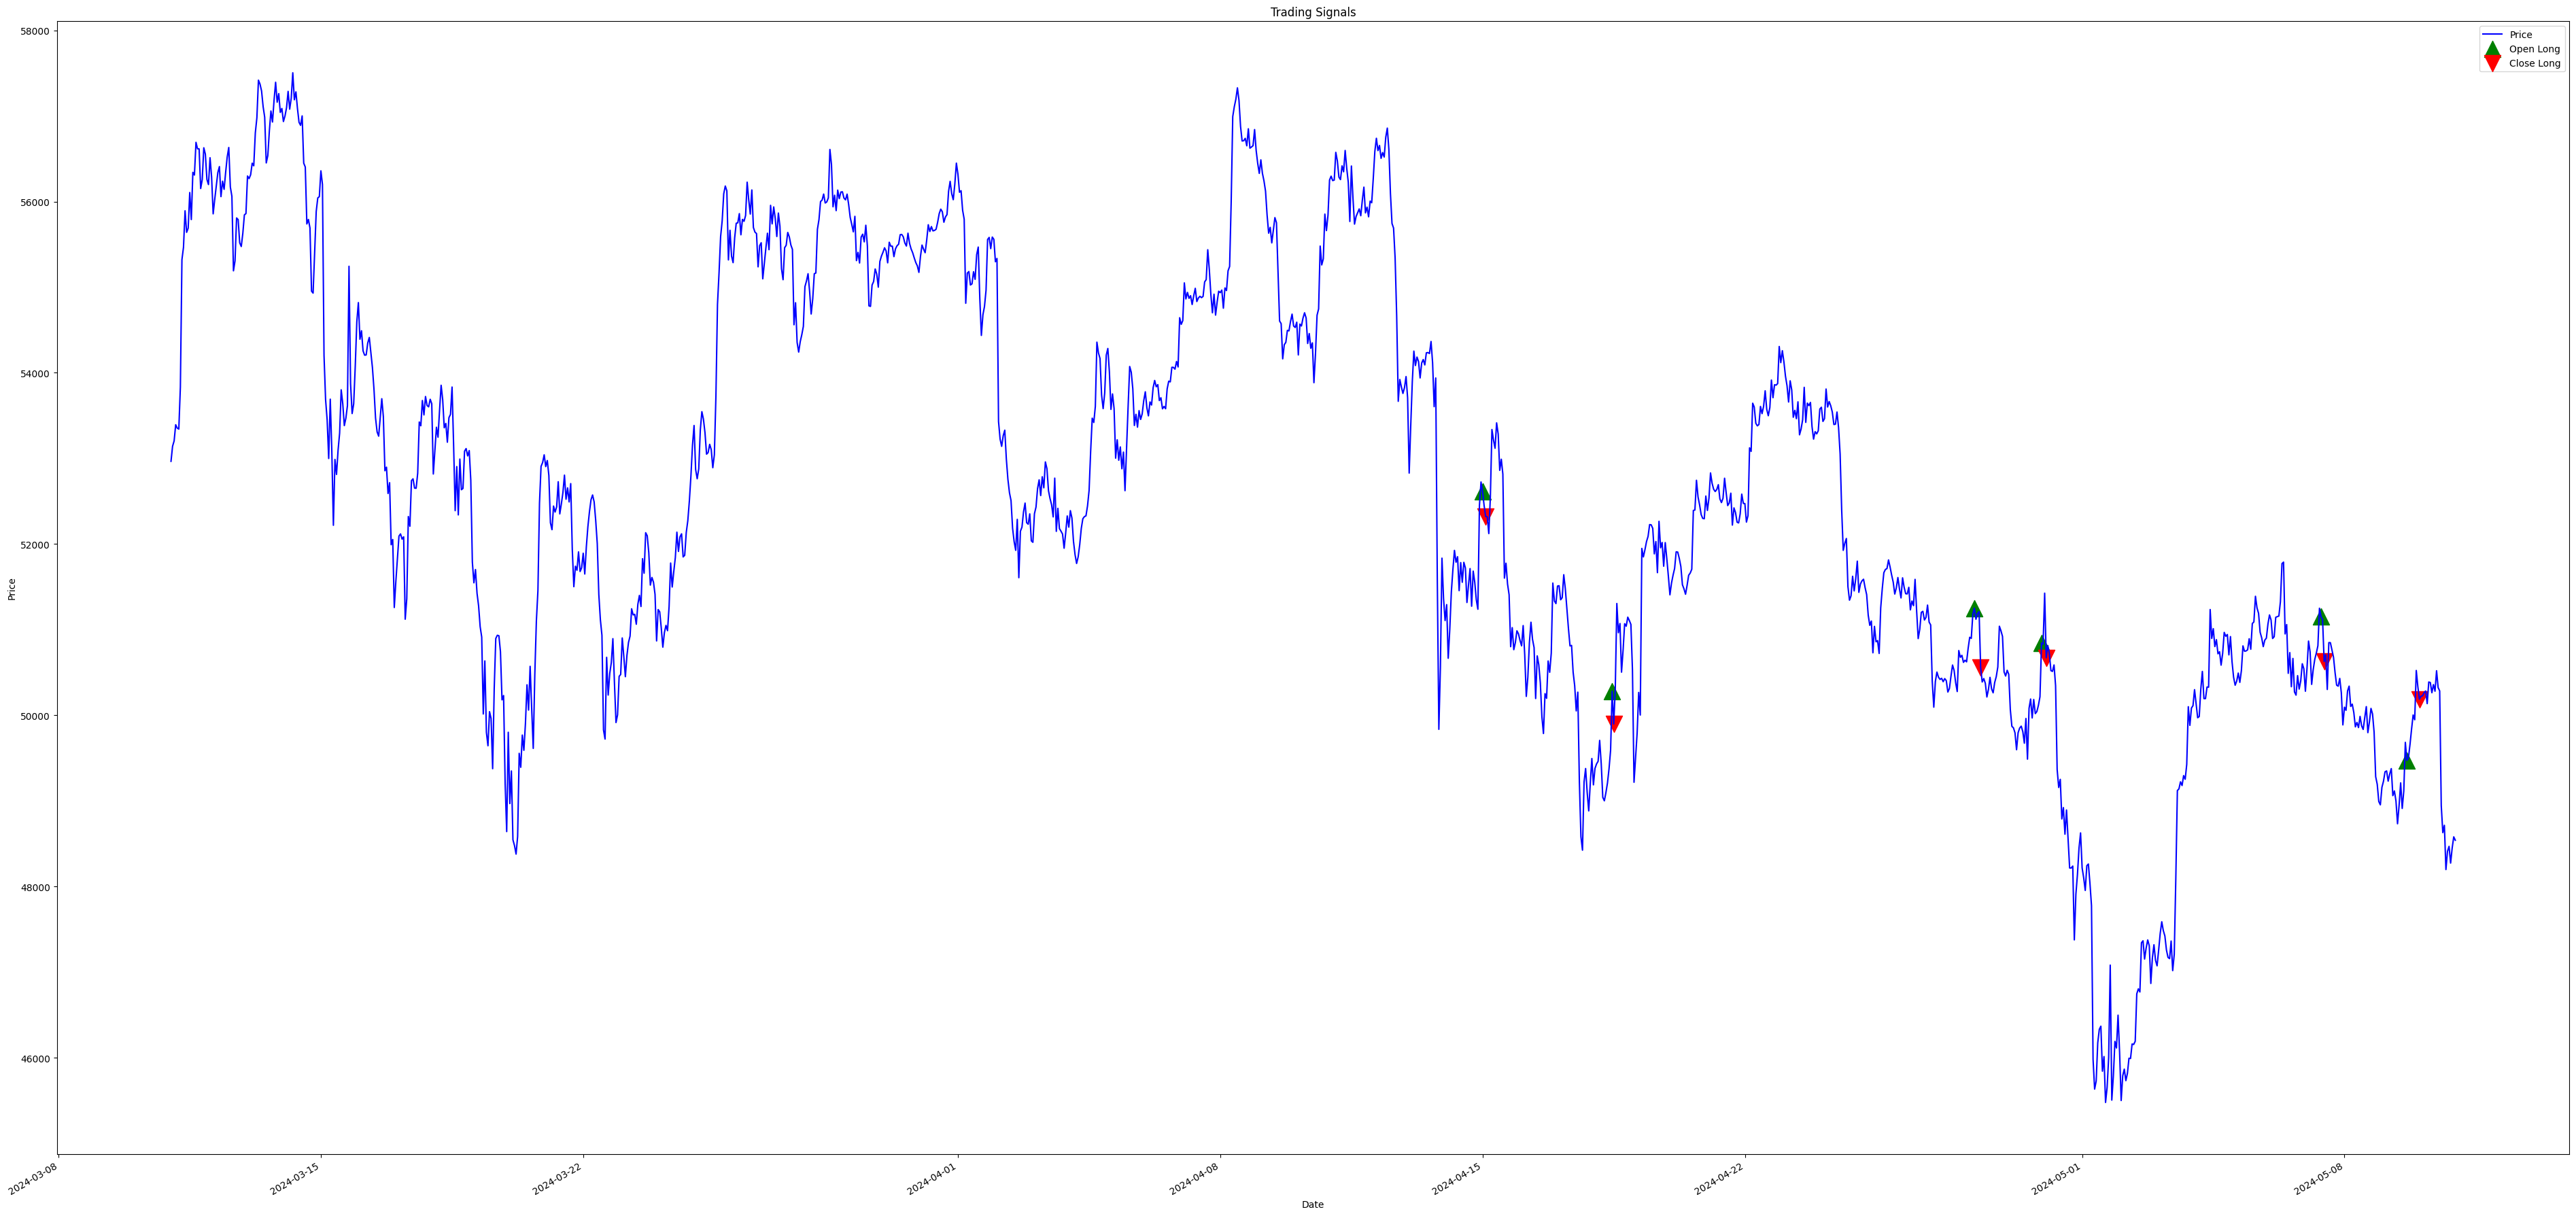

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the index to datetime if it's not already
results['history'].index = pd.to_datetime(results['history'].index)

# Create the plot
fig, ax = plt.subplots(figsize=(38, 18))

# Plot the price
ax.plot(results['history'].index, results['history']['close'], color='blue', label='Price')

# Plot green arrows for open_long
open_long = results['history'][results['history']['open_long']]
ax.scatter(open_long.index, open_long['close'], color='green', marker='^', s=300, label='Open Long')

# Plot red arrows for close_long
close_long = results['history'][results['history']['close_long']]
ax.scatter(close_long.index, close_long['close'], color='red', marker='v', s=300, label='Close Long')

# Customize the plot
ax.set_title('Trading Signals')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

# Format x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()
plt.show()
